# Import modules

In [26]:
!pip install flair emoji

In [27]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from nltk.data import load
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import emoji

import networkx as nx

from flair.embeddings import TransformerWordEmbeddings, TransformerDocumentEmbeddings
from flair.data import Sentence

from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm
import os
import sys
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn.functional as F


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric



In [29]:
from torch_geometric import seed_everything
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import is_undirected, to_undirected

In [30]:
from sklearn.metrics import confusion_matrix
from torch_geometric.nn import GATv2Conv

In [31]:
from torchvision import models
from torchsummary import summary

# Funzioni

In [ ]:
def load_data(split='train'):
    if split == 'train':
        #data = pd.read_csv('CT22_english_1C_harmful_train.tsv', sep='\t')
        data = pd.read_csv('CT22_english_1C_harmful_train.tsv', sep='\t')
        return data['tweet_text'].to_numpy(), data['class_label'].to_numpy(), data['tweet_id'].to_numpy()
    elif split == 'dev':
        data = pd.read_csv('CT22_english_1C_harmful_dev.tsv', sep='\t')
        return data['tweet_text'].to_numpy(), data['class_label'].to_numpy(), data['tweet_id'].to_numpy()
    elif split == 'test':
        data = pd.read_csv('CT22_english_1C_harmful_test.tsv', sep='\t')
        return data['tweet_text'].to_numpy(), data['topic'].to_numpy(), data['tweet_id'].to_numpy()
    else:
        sys.exit(0)


def save_graph(graph, file_name):
    path = 'TEST_GRAPHS/' + file_name + '.pickle'
    with open(path, 'wb') as handle:
        pickle.dump({'graph': graph}, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_graph(file_name, split='train'):
    if split == 'train': 
      path = 'TRAIN_GRAPHS/' + file_name + '.pickle'
    elif split == 'dev':
      path = 'DEV_GRAPHS/' + file_name + '.pickle'
    else:
      path = 'TEST_GRAPHS/' + file_name + '.pickle'
    with open(path, 'rb') as handle:
        return pickle.load(handle)['graph']

In [40]:
stop_words = set(stopwords.words('english'))

def tokenize(sentence):
    #francesco
    sentence = sentence.lower()
    sentence = re.sub(r'http\S+', '', sentence)  #remove link
    sentence = re.sub(r'covid-19', 'covid19', sentence)
    sentence = re.sub('#', '', sentence)  #hashtag removing
    sentence = " ".join(list(filter(lambda x:x[0]!='@', sentence.split()))) #remove tagged users --> "this @trump is  @fuck dump" became this is dump  
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)  #remove punctuation  including missing # and @
    #sentence = sentence.encode("ascii", "ignore")  #remove non ascii = unicode = emojis (it ignore them)
    #sentence = sentence.decode()  #return sent after removing unicode char 
    sentence = emoji.demojize(sentence) #convert emoji into text 
    sentence = nltk.word_tokenize(sentence) #see doc
    sentence = [w for w in sentence if not w.lower() in stop_words] 
    sentence = nltk.pos_tag(sentence)  #return list of tagged tuple
    return sentence

In [41]:
tokenize('This is a simple example sentence for text pre-processing, click here and see @Real_trump !!! ')

[('simple', 'JJ'),
 ('example', 'NN'),
 ('sentence', 'NN'),
 ('text', 'NN'),
 ('pre', 'NN'),
 ('processing', 'NN'),
 ('click', 'NN'),
 ('see', 'NN')]

In [ ]:
#WORD_EMBEDDING_MODEL = TransformerWordEmbeddings('bert-base-uncased')
WORD_EMBEDDING_MODEL = TransformerWordEmbeddings('google/electra-base-discriminator')
POS_TAG_DICT = load('help/tagsets/upenn_tagset.pickle')
#DOCUMENT_EMBEDDING_MODEL = TransformerDocumentEmbeddings('bert-base-uncased')
DOCUMENT_EMBEDDING_MODEL = TransformerDocumentEmbeddings('google/electra-base-discriminator')
stop_words = set(stopwords.words('english'))

def tokenize_pos_text(sentence):
    #francesco
    sentence = sentence.lower()
    sentence = re.sub(r'http\S+', '', sentence)  #remove link
    sentence = re.sub(r'covid-19', 'covid19', sentence)
    sentence = re.sub('#', '', sentence)  #hashtag removing
    sentence = " ".join(list(filter(lambda x:x[0]!='@', sentence.split()))) #remove tagged users --> "this @trump is  @fuck dump" became this is dump  
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)  #remove punctuation  including missing # and @
    #sentence = sentence.encode("ascii", "ignore")  #remove non ascii = unicode = emojis (it ignore them)
    #sentence = sentence.decode()  #return sent after removing unicode char 
    sentence = emoji.demojize(sentence) #convert emoji into text 
    sentence = nltk.word_tokenize(sentence) #see doc
    sentence = [w for w in sentence if not w.lower() in stop_words]  #remove stowords
    sentence = nltk.pos_tag(sentence)  #return list of tagged tuple
    if not sentence: 
        print('empty graph')
        sentence = [('example', 'NN'), ('sentence', 'NN'), ('read', 'VBD'), ('please', 'NN')] 
    return sentence

def tokenize_DOC(sentence):
    #francesco
    sentence = sentence.lower()
    sentence = re.sub(r'http\S+', '', sentence)  #remove link
    sentence = re.sub(r'covid-19', 'covid19', sentence)
    sentence = re.sub('#', '', sentence)  #hashtag removing
    sentence = " ".join(list(filter(lambda x:x[0]!='@', sentence.split()))) #remove tagged users --> "this @trump is  @fuck dump" became this is dump  
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)  #remove punctuation  including missing # and @
    #sentence = sentence.encode("ascii", "ignore")  #remove non ascii = unicode = emojis (it ignore them)
    #sentence = sentence.decode()  #return sent after removing unicode char 
    sentence = emoji.demojize(sentence) #convert emoji into text 
    #sentence = nltk.word_tokenize(sentence) #see doc
    #sentence = [w for w in sentence if not w.lower() in stop_words]  #remove stowords
    #sentence = nltk.pos_tag(sentence)  #return list of tagged tuple
    return sentence



def get_word_embedding(word):
    sentence = Sentence(word)
    WORD_EMBEDDING_MODEL.embed(sentence)
    word_emb = [token.embedding for token in sentence][0]
    return word_emb.cpu().detach().numpy()


def generate_text_embedding(text):
    text = tokenize_DOC(text)
    sentence = Sentence(text)
    DOCUMENT_EMBEDDING_MODEL.embed(sentence)
    return sentence.embedding.cpu().detach().numpy()


def get_one_hot_pos(tag):
    a = np.array(range(len(list(POS_TAG_DICT.keys()))))
    one_hot_vector = np.zeros((a.size, a.max() + 1))
    one_hot_vector[np.arange(a.size), a] = 1
    one_hot_dict = dict(zip(list(POS_TAG_DICT.keys()), one_hot_vector))
    results = one_hot_dict[tag]
    return results


def get_class_weights(train_graphs):
    y_tensors = []
    for graph in train_graphs:
        #y_tensors.append(torch.tensor([graph.y[0]]))
        y_tensors.append(torch.tensor([graph.label]))
    class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.asarray([0, 1]),
                                                      y=torch.cat(y_tensors).cpu().detach().numpy()), dtype=torch.float32)
    return class_weights


In [ ]:
your_embedding_dict = {} #torch.load('TIMELINE_EMB.pt')
#print([*your_embedding_dict])
import json
def get_twitter_features(tweet_id, dataset):
    relevant_metrics = []
    if dataset == 'train':
        mapping = pd.read_csv('train.csv',sep=',')
        path_pre = 'tweets_retweets/'
        user_path_pre = 'user_profiles/'
    elif dataset == 'dev':
        mapping = pd.read_csv('dev.csv', sep=',')
        path_pre = 'tweets_retweets/'
        user_path_pre = 'user_profiles/'
    elif dataset == 'dev_test':
        mapping = pd.read_csv('test.csv', sep=',')
        path_pre = 'tweets_retweets/'
        user_path_pre = 'user_profiles/'
    elif dataset == 'official test':
        path_pre = 'TEST_TW_DATA/tweets_retweets/'
        user_path_pre = 'TEST_TW_DATA/user_profiles/'
        mapping = pd.read_csv('test_real.csv', sep=',')

    folder_names = mapping['id'].to_numpy()
    tweet_ids = mapping['tweet_ids'].to_numpy()
    tweet_idx = np.where(tweet_ids == tweet_id)[0]
    if len(folder_names[tweet_idx]) > 0:
        folder_name = folder_names[tweet_idx][0]
    else:
        folder_name = ''
    
    path = path_pre + folder_name + '/tweets/' + str(tweet_id) + '.json'
    try:
        with open(path) as file:
            data = json.load(file)
        relevant_metrics.append(data['retweet_count'])
        relevant_metrics.append(data['favorite_count'])
    except:
        data = {}
        relevant_metrics.append(0)
        relevant_metrics.append(0)

    try:
        user_id = data['user']['id']
        try:
            user_path = user_path_pre + str(user_id) + '.json'
            with open(user_path) as file:
                user_data = json.load(file)            
            relevant_metrics.append(user_data['followers_count'])
            relevant_metrics.append(user_data['friends_count'])
            relevant_metrics.append(user_data['listed_count'])
            relevant_metrics.append(user_data['favourites_count'])
            if user_data['verified']:
                relevant_metrics.append(1)
            else:
                relevant_metrics.append(0)
        except:
            user_data = {}
            relevant_metrics.append(0)
            relevant_metrics.append(0)
            relevant_metrics.append(0)
            relevant_metrics.append(0)
            relevant_metrics.append(0)
            return np.array(relevant_metrics), np.zeros(768)        
        timeline_tweet_embedding = your_embedding_dict[str(user_id)+ '.json']
    except:
        relevant_metrics.append(0)
        relevant_metrics.append(0)
        relevant_metrics.append(0)
        relevant_metrics.append(0)
        relevant_metrics.append(0)
        return np.array(relevant_metrics), np.zeros(768)
    return np.array(relevant_metrics), timeline_tweet_embedding.numpy()

# Load Data

In [ ]:
X_train, Y_train, ids_train = load_data('train')
X_dev, Y_dev, ids_test = load_data('dev')

In [ ]:
#ok_ids_train = pd.read_csv('ids_train.csv')['tweet_id'].to_numpy()
#ok_ids_dev = pd.read_csv('ids_dev.csv')['tweet_id'].to_numpy()

In [ ]:
X_train, Y_train, ids_train = load_data('train')
X_dev, Y_dev, ids_test = load_data('dev')

num_0 = 0
train_graphs = []
for idx, x in enumerate(tqdm(X_train)):
    graph = load_graph('train'+str(idx), 'train')
    train_graphs.append(graph) 

dev_graphs = []
for idx, x in enumerate(tqdm(X_dev)):
    graph = load_graph('dev'+str(idx), 'dev')
    dev_graphs.append(graph)

train_loader = DataLoader(train_graphs, batch_size=512, shuffle=True)
dev_loader  = DataLoader(dev_graphs, batch_size=512, shuffle=True)

print(len(train_graphs), len(dev_graphs))
print(train_graphs[0])

100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 556.94it/s]

3323 307
Data(x=[25, 815], edge_index=[2, 144], label=[1], document_embedding=[768])


# Model

In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

HEADS = 4

class GCN(torch.nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super().__init__()
        self.conv1 = GATv2Conv(num_input,  num_hidden,heads= HEADS, add_self_loops=False)
        self.conv2 = GATv2Conv(num_hidden*HEADS, num_hidden, add_self_loops=False)

        self.lin1  = torch.nn.Linear(num_hidden + int(768), int((num_hidden +  768)/2))
        #self.lin2  = torch.nn.Linear(int((num_hidden +  768)/2), int((num_hidden +  768)/10))
        self.lin3  = torch.nn.Linear(int((num_hidden +  768)/2), num_output)

        # uncomment if you want to use twitter features in the model
        '''
        self.lin1  = torch.nn.Linear(num_hidden + int(768 + 7), int((num_hidden +  768)/2))
        #self.lin2  = torch.nn.Linear(int((num_hidden +  768)/2), int((num_hidden +  768)/10))
        self.lin3  = torch.nn.Linear(int((num_hidden +  768)/2), num_output)
        '''

    def forward(self, data):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        #print('x.shape', x.shape, 'doc emb shape', torch.FloatTensor(np.asarray(data['document_embedding'])).shape)   
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_max_pool(x, batch_idx)
        x = torch.cat([x, 
                       torch.cuda.FloatTensor(np.asarray(data['document_embedding'])),
                       #torch.FloatTensor(np.asarray(data['user_emb'])) # UNCOMMENT THIS LINE IN CASE OF USING TWITTER FEATURES
                       ], dim=1)
        
        x = F.dropout(x, p=0.750, training=self.training)

        x = self.lin1(x)
        x = F.relu(x)
        #x = self.lin2(x)
        #x = F.relu(x)
        x = self.lin3(x)

        return x


def train_model(model, train_loader, loss_fct, optimizer):
    model.train()
    avg_loss = []
    for batch_idx, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
        data.to(DEVICE)
        out = model(data)  # Perform a single forward pass.
        loss = loss_fct(out, data.label)  # Compute the loss.
        avg_loss.append(loss.item())
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    scheduler.step()
    return np.mean(avg_loss)

def eval_model(model, test_loader, loss_fct,print_classification_report=False ):
    model.eval()
    correct = 0
    true_y = []
    pred_y = []
    avg_loss_test = []
    for data in test_loader:  # Iterate in batches over the training/test dataset.
        data.to(DEVICE)
        out = model(data)
        loss = loss_fct(out, data.label)  # Compute the loss.
        avg_loss_test.append(loss.item())
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        pred_y.append(pred.cpu().detach().numpy())
        correct += int((pred == data.label).sum())  # Check against ground-truth labels.
        true_y.append(data.label.cpu().detach().numpy())
    #print(confusion_matrix(np.concatenate(true_y), np.concatenate(pred_y)))
    if print_classification_report:
        print(classification_report(np.concatenate(true_y), np.concatenate(pred_y), digits=5))
    return np.mean(avg_loss_test) ,accuracy_score(np.concatenate(true_y), np.concatenate(pred_y)), precision_score(np.concatenate(true_y), np.concatenate(pred_y), average='macro'),  recall_score(np.concatenate(true_y), np.concatenate(pred_y), average='macro'), f1_score(np.concatenate(true_y), np.concatenate(pred_y), pos_label=1 , average='binary')


def train_eval_model(model, train_loader, test_loader, loss_fct, optimizer, num_epochs=1, verbose=1):
    l_dev_f1 = []
    model.to(DEVICE)
    for epoch in range(1, num_epochs+1):
        
        avgloss_train = train_model(model=model, train_loader=train_loader, loss_fct=loss_fct, optimizer=optimizer)
        _ , train_acc, train_p, train_r, train_f1 = eval_model(model, train_loader, loss_fct=loss_fct)
        if epoch == num_epochs:
            avgtestloss, test_acc, test_p, test_r, test_f1 = eval_model(model, test_loader,loss_fct=loss_fct, print_classification_report=False)
            l_dev_f1.append(test_f1)
            if test_f1 >= max(l_dev_f1):
                torch.save(model.state_dict(), 'model_best.pth')
            return test_acc, test_p, test_r, test_f1, l_dev_f1
        else:
            avgtestloss, test_acc, test_p, test_r, test_f1 = eval_model(model, test_loader, loss_fct=loss_fct)
            l_dev_f1.append(test_f1)
            if test_f1 >= max(l_dev_f1):
                torch.save(model.state_dict(), 'model_best.pth')
            if verbose == 1:
                print(f'Ep{epoch:03d},TrainAc{train_acc:.2f},TestAc{test_acc:.2f},TrainF1:{train_f1:.2f},TestF1:{test_f1:.2f},TrainLos{avgloss_train:.4f},TestLos{avgtestloss:.4f}')
                #print()# ,LR{scheduler.get_last_lr()}
                #print()


In [33]:
def gnn_model_summary(model):
    print("----------------------------------------------------------------")
    print('Model Parameters')
    #print("----------------------------------------------------------------")
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [34]:
model_to_print = GCN(815, 
            450, 
            2)

gnn_model_summary(model_to_print)
print()
print("----------------------------------------------------------------")
print('Model Architechture')
print("----------------------------------------------------------------")
print(model_to_print)

----------------------------------------------------------------
Model Parameters
----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
           conv1.att                [1, 4, 450]            1800
          conv1.bias                     [1800]            1800
  conv1.lin_l.weight                [1800, 815]         1467000
    conv1.lin_l.bias                     [1800]            1800
  conv1.lin_r.weight                [1800, 815]         1467000
    conv1.lin_r.bias                     [1800]            1800
           conv2.att                [1, 1, 450]             450
          conv2.bias                      [450]             450
  conv2.lin_l.weight                [450, 1800]          810000
    conv2.lin_l.bias                      [450]             450
  conv2.lin_r.weight                [450, 1800]          810000
    conv2.lin_r.bias

# Train evaluate

GCN(
  (conv1): GATv2Conv(815, 101, heads=16)
  (conv2): GATv2Conv(1616, 101, heads=1)
  (lin1): Linear(in_features=869, out_features=434, bias=True)
  (lin3): Linear(in_features=434, out_features=2, bias=True)
)
Ep001,TrainAc0.49,TestAc0.53,TrainF1:0.17,TestF1:0.18,TrainLos0.6997,TestLos0.6936
Ep002,TrainAc0.35,TestAc0.38,TrainF1:0.18,TestF1:0.18,TrainLos0.6941,TestLos0.6925
Ep003,TrainAc0.33,TestAc0.35,TrainF1:0.18,TestF1:0.17,TrainLos0.6985,TestLos0.6919
Ep004,TrainAc0.28,TestAc0.30,TrainF1:0.17,TestF1:0.19,TrainLos0.6976,TestLos0.6912
Ep005,TrainAc0.24,TestAc0.27,TrainF1:0.17,TestF1:0.20,TrainLos0.6940,TestLos0.6906
Ep006,TrainAc0.24,TestAc0.27,TrainF1:0.17,TestF1:0.20,TrainLos0.6934,TestLos0.6901
Ep007,TrainAc0.29,TestAc0.32,TrainF1:0.18,TestF1:0.21,TrainLos0.6909,TestLos0.6900
Ep008,TrainAc0.33,TestAc0.35,TrainF1:0.19,TestF1:0.21,TrainLos0.6949,TestLos0.6897
Ep009,TrainAc0.34,TestAc0.36,TrainF1:0.19,TestF1:0.20,TrainLos0.6954,TestLos0.6893
Ep010,TrainAc0.35,TestAc0.37,TrainF1:0.1

Ep098,TrainAc0.70,TestAc0.67,TrainF1:0.31,TestF1:0.31,TrainLos0.6408,TestLos0.6344
Ep099,TrainAc0.70,TestAc0.67,TrainF1:0.32,TestF1:0.30,TrainLos0.6446,TestLos0.6329
Ep100,TrainAc0.70,TestAc0.67,TrainF1:0.32,TestF1:0.31,TrainLos0.6317,TestLos0.6315
Ep101,TrainAc0.69,TestAc0.65,TrainF1:0.31,TestF1:0.29,TrainLos0.6332,TestLos0.6296
Ep102,TrainAc0.70,TestAc0.66,TrainF1:0.32,TestF1:0.30,TrainLos0.6382,TestLos0.6284
Ep103,TrainAc0.71,TestAc0.67,TrainF1:0.32,TestF1:0.30,TrainLos0.6398,TestLos0.6277
Ep104,TrainAc0.70,TestAc0.67,TrainF1:0.32,TestF1:0.30,TrainLos0.6372,TestLos0.6262
Ep105,TrainAc0.71,TestAc0.67,TrainF1:0.32,TestF1:0.30,TrainLos0.6359,TestLos0.6248
Ep106,TrainAc0.70,TestAc0.66,TrainF1:0.32,TestF1:0.30,TrainLos0.6327,TestLos0.6232
Ep107,TrainAc0.68,TestAc0.65,TrainF1:0.31,TestF1:0.30,TrainLos0.6287,TestLos0.6215
Ep108,TrainAc0.71,TestAc0.67,TrainF1:0.31,TestF1:0.31,TrainLos0.6334,TestLos0.6208
Ep109,TrainAc0.71,TestAc0.68,TrainF1:0.31,TestF1:0.31,TrainLos0.6255,TestLos0.6194
Ep11

Ep197,TrainAc0.75,TestAc0.70,TrainF1:0.38,TestF1:0.29,TrainLos0.5153,TestLos0.5817
Ep198,TrainAc0.76,TestAc0.71,TrainF1:0.39,TestF1:0.30,TrainLos0.5039,TestLos0.5836
Ep199,TrainAc0.77,TestAc0.73,TrainF1:0.39,TestF1:0.30,TrainLos0.5072,TestLos0.5861
Ep200,TrainAc0.77,TestAc0.73,TrainF1:0.40,TestF1:0.30,TrainLos0.5058,TestLos0.5863
Ep201,TrainAc0.76,TestAc0.71,TrainF1:0.39,TestF1:0.29,TrainLos0.5030,TestLos0.5839
Ep202,TrainAc0.76,TestAc0.70,TrainF1:0.39,TestF1:0.28,TrainLos0.5038,TestLos0.5842
Ep203,TrainAc0.76,TestAc0.70,TrainF1:0.40,TestF1:0.28,TrainLos0.5049,TestLos0.5842
Ep204,TrainAc0.76,TestAc0.70,TrainF1:0.39,TestF1:0.28,TrainLos0.4978,TestLos0.5836
Ep205,TrainAc0.76,TestAc0.70,TrainF1:0.40,TestF1:0.28,TrainLos0.4993,TestLos0.5839
Ep206,TrainAc0.76,TestAc0.70,TrainF1:0.39,TestF1:0.28,TrainLos0.5050,TestLos0.5832
Ep207,TrainAc0.76,TestAc0.70,TrainF1:0.39,TestF1:0.28,TrainLos0.4992,TestLos0.5835
Ep208,TrainAc0.76,TestAc0.70,TrainF1:0.39,TestF1:0.28,TrainLos0.5071,TestLos0.5826
Ep20

Ep296,TrainAc0.83,TestAc0.77,TrainF1:0.49,TestF1:0.34,TrainLos0.3765,TestLos0.6425
Ep297,TrainAc0.84,TestAc0.79,TrainF1:0.50,TestF1:0.34,TrainLos0.3662,TestLos0.6532
Ep298,TrainAc0.84,TestAc0.79,TrainF1:0.51,TestF1:0.33,TrainLos0.3574,TestLos0.6618
Ep299,TrainAc0.84,TestAc0.79,TrainF1:0.50,TestF1:0.33,TrainLos0.3617,TestLos0.6579
Ep300,TrainAc0.83,TestAc0.78,TrainF1:0.50,TestF1:0.33,TrainLos0.3632,TestLos0.6484
Ep301,TrainAc0.83,TestAc0.78,TrainF1:0.50,TestF1:0.33,TrainLos0.3602,TestLos0.6521
Ep302,TrainAc0.83,TestAc0.77,TrainF1:0.50,TestF1:0.33,TrainLos0.3677,TestLos0.6503
Ep303,TrainAc0.83,TestAc0.77,TrainF1:0.49,TestF1:0.34,TrainLos0.3615,TestLos0.6445
Ep304,TrainAc0.84,TestAc0.79,TrainF1:0.50,TestF1:0.34,TrainLos0.3690,TestLos0.6536
Ep305,TrainAc0.84,TestAc0.78,TrainF1:0.51,TestF1:0.32,TrainLos0.3521,TestLos0.6617
Ep306,TrainAc0.84,TestAc0.78,TrainF1:0.51,TestF1:0.34,TrainLos0.3512,TestLos0.6558
Ep307,TrainAc0.84,TestAc0.78,TrainF1:0.51,TestF1:0.32,TrainLos0.3538,TestLos0.6598
Ep30

Ep395,TrainAc0.90,TestAc0.82,TrainF1:0.63,TestF1:0.30,TrainLos0.2505,TestLos0.8782
Ep396,TrainAc0.90,TestAc0.82,TrainF1:0.62,TestF1:0.30,TrainLos0.2464,TestLos0.8702
Ep397,TrainAc0.89,TestAc0.80,TrainF1:0.61,TestF1:0.29,TrainLos0.2446,TestLos0.8580
Ep398,TrainAc0.89,TestAc0.80,TrainF1:0.61,TestF1:0.29,TrainLos0.2476,TestLos0.8515
Ep399,TrainAc0.89,TestAc0.82,TrainF1:0.62,TestF1:0.30,TrainLos0.2411,TestLos0.8763
Ep400,TrainAc0.90,TestAc0.82,TrainF1:0.63,TestF1:0.30,TrainLos0.2462,TestLos0.8816
Ep401,TrainAc0.89,TestAc0.80,TrainF1:0.61,TestF1:0.29,TrainLos0.2372,TestLos0.8580
Ep402,TrainAc0.89,TestAc0.81,TrainF1:0.62,TestF1:0.29,TrainLos0.2372,TestLos0.8766
Ep403,TrainAc0.91,TestAc0.83,TrainF1:0.64,TestF1:0.32,TrainLos0.2382,TestLos0.9198
Ep404,TrainAc0.89,TestAc0.80,TrainF1:0.62,TestF1:0.29,TrainLos0.2453,TestLos0.8703
Ep405,TrainAc0.90,TestAc0.81,TrainF1:0.62,TestF1:0.30,TrainLos0.2304,TestLos0.8828
Ep406,TrainAc0.90,TestAc0.83,TrainF1:0.64,TestF1:0.32,TrainLos0.2421,TestLos0.9159
Ep40

Ep494,TrainAc0.92,TestAc0.84,TrainF1:0.70,TestF1:0.31,TrainLos0.1663,TestLos1.2158
Ep495,TrainAc0.93,TestAc0.84,TrainF1:0.73,TestF1:0.29,TrainLos0.1641,TestLos1.2892
Ep496,TrainAc0.94,TestAc0.85,TrainF1:0.74,TestF1:0.30,TrainLos0.1638,TestLos1.3388
Ep497,TrainAc0.93,TestAc0.84,TrainF1:0.71,TestF1:0.31,TrainLos0.1641,TestLos1.2444
Ep498,TrainAc0.93,TestAc0.84,TrainF1:0.72,TestF1:0.31,TrainLos0.1575,TestLos1.2558
Ep499,TrainAc0.94,TestAc0.84,TrainF1:0.74,TestF1:0.29,TrainLos0.1591,TestLos1.3280
max f1 score 0.3519


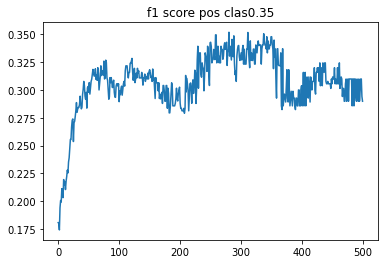

In [ ]:
seed_everything(1234)

EPOCHS = 500
input_dimension  = train_graphs[0].x.size()[1]
hidden_dimension = int(input_dimension/8)
output_dimension = 2


class_weights = get_class_weights(train_graphs)


model = GCN(input_dimension, 
            hidden_dimension, 
            output_dimension)

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.95)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion.to(DEVICE)

test_acc, test_p, test_r, test_f1, l_dev_f1 = train_eval_model(model=model, 
                                                               train_loader =train_loader, 
                                                               test_loader  =dev_loader, 
                                                               loss_fct  = criterion,
                                                               optimizer = optimizer, 
                                                               num_epochs= EPOCHS, 
                                                               verbose =1)


print('max f1 score', round(max(l_dev_f1),4))
plt.plot(l_dev_f1)
plt.title('f1 score pos clas'+str(round(max(l_dev_f1),2)))
plt.show()

In [ ]:
trained_model = GCN(input_dimension, 
                    hidden_dimension, 
                    output_dimension)
trained_model.to(DEVICE)

PATH ='model_best.pth'
trained_model.load_state_dict(torch.load(PATH))
trained_model.eval()

def load_graph(file_name):
    path = 'TEST_GRAPHS/' + file_name
    with open(path, 'rb') as handle:
        return pickle.load(handle)['graph']

mappings = pd.read_csv('test_real.csv')
folder_ids = mappings['id'].to_numpy()
tweet_ids = mappings['tweet_ids'].to_numpy()

test_graphs = []
file_names = os.listdir('TEST_GRAPHS/')
file_names = [file for file in file_names if file.endswith('pickle')]

for idx, file_name in enumerate(tqdm(file_names)):

    graph = load_graph(file_name)
    value = file_name.split('.')[0]
    value = 'test'+str(int(value[4:])+1)

    idx_folder = np.where(folder_ids == value)[0]
    tweet_id = tweet_ids[idx_folder]
    user_feat , timeline_emb = get_twitter_features(tweet_id, 'official test')
    graph['user_emb'] = user_feat 
    test_graphs.append(graph)

test_loader = DataLoader(test_graphs, batch_size=64, shuffle=False)

predictions = []
for data in test_loader:  # Iterate in batches over the training/test dataset.
    data.to(DEVICE)
    out = trained_model(data)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    predictions.append(pred.cpu().detach().numpy())

predictions = np.concatenate(np.array(predictions))
print("predictions",predictions)


output_file = open('pred.tsv', 'w')
output_file.write('topic' + '\t' + 'tweet_id' + '\t' + 'class_label' + '\t' +  'run_id' + '\n')

for idx, value in enumerate(file_names):
    value = value.split('.')[0]
    value = 'test'+str(int(value[4:])+1)
    idx_folder = np.where(folder_ids == value)[0]
    tweet_id = tweet_ids[idx_folder]
    output_file.write('COVID-19' + '\t' + str(tweet_id[0]) + '\t' + str(predictions[idx]) + '\t' + 'model_1' + '\n')

output_file.close()

100%|███████████████████████████████████████████████████████████████████████████████| 251/251 [00:01<00:00, 215.69it/s]

predictions [1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0
 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0
 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1]



C:\Users\dimit\AppData\Local\Temp/ipykernel_34820/4289276645.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions = np.concatenate(np.array(predictions))


# Optional: train and dev loaders with twitter features

Info: modify the dimension of the hidden layers in the model and how the concatenation is perfromed during forward pass above in case of training with twitter data.

In [ ]:
X_train, Y_train, ids_train = load_data('train')
X_dev, Y_dev, ids_dev = load_data('dev')

#crete graphs
num_0 = 0
train_graphs = []
for idx, x in enumerate(tqdm(X_train)):
    tweet_id = ids_train[idx]
    graph = load_graph('train'+str(idx), 'train')
    user_feat , timeline_emb = get_twitter_features(tweet_id, 'train')
    graph['user_emb'] = user_feat 
    train_graphs.append(graph) 

dev_graphs = []
for idx, x in enumerate(tqdm(X_dev)):
    tweet_id = ids_dev[idx]
    graph = load_graph('dev'+str(idx), 'dev')
    user_feat , timeline_emb = get_twitter_features(tweet_id, 'dev')
    graph['user_emb'] = user_feat 
    dev_graphs.append(graph)

train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
dev_loader  = DataLoader(dev_graphs, batch_size=64, shuffle=True)
    
print(len(train_graphs), len(dev_graphs))
print(train_graphs[0])

  0%|                                                                                         | 0/3323 [00:00<?, ?it/s]


TypeError: load_graph() takes 1 positional argument but 2 were given